In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

## Load Data

In [2]:
import cifar10

Set the path for storing the data-set on your computer.

The CIFAR-10 data-set is about 163 MB and will be downloaded automatically if it is not located in the given path.

In [3]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


Load the class-names.

In [4]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Load the training-set. This returns the images, the class-numbers as integers, and the class-numbers as One-Hot encoded arrays called labels.

In [5]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


Load the test-set.

In [6]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


The CIFAR-10 data-set has now been loaded and consists of 60,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


The data dimensions are used in several places in the source-code below. They have already been defined in the cifar10 module, so we just need to import them.

In [8]:
from cifar10 import img_size, num_channels, num_classes

The images are 32 x 32 pixels, but we will crop the images to 24 x 24 pixels.

In [9]:
img_size_cropped = 24

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [10]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

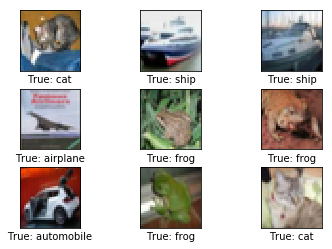

In [11]:
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

The pixelated images above are what the neural network will get as input. The images might be a bit easier for the human eye to recognize if we smoothen the pixels.

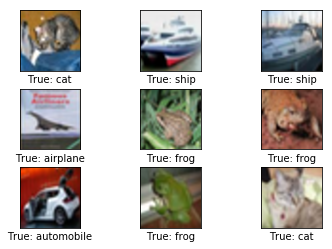

In [12]:
plot_images(images=images, cls_true=cls_true, smooth=True)

In [13]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

In [14]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [15]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### Data augmentation for images

The following helper-functions create the part of the TensorFlow computational graph that pre-processes the input images. Nothing is actually calculated at this point, the function merely adds nodes to the computational graph for TensorFlow.

The pre-processing is different for training and testing of the neural network:
* For training, the input images are randomly cropped, randomly flipped horizontally, and the hue, contrast and saturation is adjusted with random values. This artificially inflates the size of the training-set by creating random variations of the original input images. Examples of distorted images are shown further below.

* For testing, the input images are cropped around the centre and nothing else is adjusted.

In [16]:
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        with tf.device('/cpu:0'):
            # For training, add the following to the TensorFlow graph.

            # Randomly crop the input image.
            image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

            # Randomly flip the image horizontally.
            image = tf.image.random_flip_left_right(image)

            # Randomly adjust hue, contrast and saturation.
            image = tf.image.random_hue(image, max_delta=0.05)
            image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
            image = tf.image.random_brightness(image, max_delta=0.2)
            image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

            # Some of these functions may overflow and result in pixel
            # values beyond the [0, 1] range. It is unclear from the
            # documentation of TensorFlow whether this is
            # intended. A simple solution is to limit the range.

            # Limit the image pixels between [0, 1] in case of overflow.
            image = tf.minimum(image, 1.0)
            image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

The function above is called for each image in the input batch using the following function.

In [17]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    with tf.device('/cpu:0'):
        images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In order to plot the distorted images, we create the pre-processing graph for TensorFlow, so we may execute it later.

In [18]:
distorted_images = pre_process(images=x, training=True)

### Creating Main Processing

In [19]:
keep_probab = tf.placeholder(dtype=tf.float32, shape=(), name="keep_probab")

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.get_variable(initializer=initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.5, shape=shape)
    return tf.get_variable(initializer=initial, name=name)

def create_conv_layer(X, conv_shape, conv_stride, name):
    with tf.variable_scope(name):
        w = weight_variable(conv_shape, "w")
        b = bias_variable((conv_shape[3], ), "b")
        return tf.nn.relu(tf.add(tf.nn.conv2d(X, w, strides=(1, ) + conv_stride + (1, ), padding="SAME", name="conv"), b), name="output")
    
def create_pooling_layer(X, pool_shape, pool_stride, name):
    with tf.variable_scope(name):
        return tf.nn.max_pool(X, (1,) + pool_shape +  (1,), (1, ) + pool_stride + (1, ), padding="SAME", name="max_pool")
    
def create_dense_layer(X, func, shape, keep_probab, name):
    with tf.variable_scope(name):
        w = weight_variable(shape, "w")
        b = bias_variable((shape[1], ), "b")
        X_drop = tf.nn.dropout(X, keep_probab, name="dropout")
        return func(tf.matmul(X_drop, w) + b, name="output")
    
def main_network(images, training):
    
    layer1_1 = create_conv_layer(images, (5, 5, 3, 48), (1, 1), "layer1_1")
    layer1_2 = create_conv_layer(images, (5, 5, 3, 48), (1, 1), "layer1_2")
    layer2_1 = create_conv_layer(layer1_1, (5, 5, 48, 128), (1, 1), "layer2_1")
    layer2_2 = create_conv_layer(layer1_2, (5, 5, 48, 128), (1, 1), "layer2_2")
    layer3_1 = create_pooling_layer(layer2_1, (2, 2), (2, 2), "layer3_1")
    layer3_2 = create_pooling_layer(layer2_2, (2, 2), (2, 2), "layer3_2")
    layer3_sum = tf.add(layer3_1, layer3_2, "layer3_sum")
    layer4_1 = create_conv_layer(layer3_sum , (3, 3, 128, 192), (1, 1), "layer4_1")
    layer4_2 = create_conv_layer(layer3_sum , (3, 3, 128, 192), (1, 1), "layer4_2")
    layer5_1 = create_conv_layer(layer4_1, (3, 3, 192, 192), (1, 1), "layer5_1")
    layer5_2 = create_conv_layer(layer4_2, (3, 3, 192, 192), (1, 1), "layer5_2")
    layer6_1 = create_conv_layer(layer5_1, (3, 3, 192, 128), (1, 1), "layer6_1")
    layer6_2 = create_conv_layer(layer5_2, (3, 3, 192, 128), (1, 1), "layer6_2")
    flat_1 = tf.reshape(layer6_1, (-1, 12 * 12 * 128))
    flat_2 = tf.reshape(layer6_2, (-1, 12 * 12 * 128))
    layer7_1 = create_dense_layer(flat_1, tf.nn.relu, (12 * 12 * 128, 1024), keep_probab, "layer7_1")
    layer7_2 = create_dense_layer(flat_2, tf.nn.relu, (12 * 12 * 128, 1024), keep_probab, "layer7_2")
    layer8_1 = create_dense_layer(layer7_1, tf.nn.relu, (1024, 1024), keep_probab, "layer8_1")
    layer8_2 = create_dense_layer(layer7_2, tf.nn.relu, (1024, 1024), keep_probab, "layer8_2")

    w_out = weight_variable((1024, 10), "w_out")
    b_out = bias_variable((10,) , "b_out")
    out = tf.add(tf.matmul(layer8_1 + layer8_2, w_out), b_out, "out")
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=out))
    
    return out, loss

### Creating Neural Network

Note that the neural network is enclosed in the variable-scope named 'network'. This is because we are actually creating two neural networks in the TensorFlow graph. By assigning a variable-scope like this, we can re-use the variables for the two neural networks, so the variables that are optimized for the training-network are re-used for the other network that is used for testing.

In [20]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training=training)

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

### Create Neural Network for Training Phase

Note that `trainable=False` which means that TensorFlow will not try to optimize this variable.

In [21]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

Create the neural network to be used for training. The `create_network()` function returns both `y_pred` and `loss`, but we only need the `loss`-function during training.

In [22]:
_, loss = create_network(training=True)

Create an optimizer which will minimize the `loss`-function. Also pass the `global_step` variable to the optimizer so it will be increased by one after each iteration.

In [23]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

### Create Neural Network for Test Phase / Inference

Now create the neural network for the test-phase. Once again the `create_network()` function returns the predicted class-labels `y_pred` for the input images, as well as the `loss`-function to be used during optimization. During testing we only need `y_pred`.

In [24]:
y_pred, loss_pred = create_network(training=False)

We then calculate the predicted class number as an integer. The output of the network `y_pred` is an array with 10 elements. The class number is the index of the largest element in the array.

In [25]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Instructions for updating:
Use the `axis` argument instead


Then we create a vector of booleans telling us whether the predicted class equals the true class of each image.

In [26]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [27]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

In order to save the variables of the neural network, so they can be reloaded quickly without having to train the network again, we now create a so-called Saver-object which is used for storing and retrieving all the variables of the TensorFlow graph. Nothing is actually saved at this point, which will be done further below.

In [28]:
saver = tf.train.Saver()

### Getting the Weights

Further below, we want to plot the weights of the neural network. When the network is constructed using Pretty Tensor, all the variables of the layers are created indirectly by Pretty Tensor. We therefore have to retrieve the variables from TensorFlow.

We used the names `layer_conv1` and `layer_conv2` for the two convolutional layers. These are also called variable scopes. Pretty Tensor automatically gives names to the variables it creates for each layer, so we can retrieve the weights for a layer using the layer's scope-name and the variable-name.

The implementation is somewhat awkward because we have to use the TensorFlow function `get_variable()` which was designed for another purpose; either creating a new variable or re-using an existing variable. The easiest thing is to make the following helper-function.

In [29]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('w')

    return variable

Using this helper-function we can retrieve the variables. These are TensorFlow objects. In order to get the contents of the variables, you must do something like: `contents = session.run(weights_conv1)` as demonstrated further below.

In [30]:
weights_conv1 = get_weights_variable(layer_name='layer1_1')
weights_conv2 = get_weights_variable(layer_name='layer2_1')

In [31]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(weights_conv1).shape)

(5, 5, 3, 48)


In [32]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(weights_conv2).shape)

(5, 5, 48, 128)


### Getting the Layer Outputs

Similarly we also need to retrieve the outputs of the convolutional layers. The function for doing this is slightly different than the function above for getting the weights. Here we instead retrieve the last tensor that is output by the convolutional layer.

In [33]:
def get_layer_output(layer_name):
    # The name of the last operation of the convolutional layer.
    # This assumes you are using Relu as the activation-function.
    tensor_name = "network/" + layer_name + "/output:0"

    # Get the tensor with this name.
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

Get the output of the convoluational layers so we can plot them later.

In [34]:
output_conv1 = get_layer_output(layer_name='layer1_1')
output_conv2 = get_layer_output(layer_name='layer2_1')

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [35]:
session = tf.Session()

### Restore or initialize variables

Training this neural network may take a long time, especially if you do not have a GPU. We therefore save checkpoints during training so we can continue training at another time (e.g. during the night), and also for performing analysis later without having to train the neural network every time we want to use it.

If you want to restart the training of the neural network, you have to delete the checkpoints first.

This is the directory used for the checkpoints.

In [36]:
save_dir = 'checkpoints/'

Create the directory if it does not exist.

In [37]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

This is the base-filename for the checkpoints, TensorFlow will append the iteration number, etc.

In [38]:
save_path = os.path.join(save_dir, 'cifar10_cnn')

First try to restore the latest checkpoint. This may fail and raise an exception e.g. if such a checkpoint does not exist, or if you have changed the TensorFlow graph.

In [39]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints/cifar10_cnn-86000
Restored checkpoint from: checkpoints/cifar10_cnn-86000


### Helper-function to get a random training-batch

There are 50,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [40]:
train_batch_size = 64

Function for selecting a random batch of images from the training-set.

In [41]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

### Optimization

The progress is printed every 100 iterations. A checkpoint is saved every 1000 iterations and also after the last iteration.

In [42]:
from tqdm import tqdm

def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in tqdm(range(num_iterations)):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch,
                           keep_probab: 0.5}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 250 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

        # Save a checkpoint to disk every 1000 iterations (and last).
        if (i_global % 10000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [43]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Plot confusion matrix

In [44]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Calculating classifications

This function calculates the predicted classes of images and also returns a boolean array whether the classification of each image is correct.

The calculation is done in batches because it might use too much RAM otherwise. If your computer crashes then you can try and lower the batch-size.

In [45]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls_and_loss(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    l_pred = np.zeros(shape=num_images, dtype=np.float32)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :], 
                     keep_probab: 1.0}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j], l_pred[i:j] = session.run([y_pred_cls, loss_pred], feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred, l_pred

Calculate the predicted class for the test-set.

In [46]:
def predict_cls_test_and_loss():
    return predict_cls_and_loss(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Helper-functions for the classification accuracy

This function calculates the classification accuracy given a boolean array whether each image was correctly classified. E.g. `classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4`. The function also returns the number of correct classifications.

In [47]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    
    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

In [48]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred, loss = predict_cls_test_and_loss()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2}), loss on Test-Set: {3:.4f}"
    print(msg.format(acc, num_correct, num_images, loss.mean()))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Helper-function for plotting convolutional weights

In [49]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for plotting the output of convolutional layers

In [50]:
def plot_layer_output(layer_output, image):
    # Assume layer_output is a 4-dim tensor
    # e.g. output_conv1 or output_conv2.

    # Create a feed-dict which holds the single input image.
    # Note that TensorFlow needs a list of images,
    # so we just create a list with this one image.
    feed_dict = {x: [image]}
    
    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)

    # Get the lowest and highest values.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    values_min = np.min(values)
    values_max = np.max(values)

    # Number of image channels output by the conv. layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_images))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Examples of distorted input images

In order to artificially inflate the number of images available for training, the neural network uses pre-processing with random distortions of the input images. This should hopefully make the neural network more flexible at recognizing and classifying images.

This is a helper-function for plotting distorted input images.

In [51]:
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    # Create a feed-dict for TensorFlow.
    feed_dict = {x: image_duplicates}

    # Calculate only the pre-processing of the TensorFlow graph
    # which distorts the images in the feed-dict.
    result = session.run(distorted_images, feed_dict=feed_dict)

    # Plot the images.
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

Helper-function for getting an image and its class-number from the test-set.

In [52]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

Get an image and its true class from the test-set.

In [53]:
img, cls = get_test_image(16)

Plot 9 random distortions of the image. If you re-run this code you will get slightly different results.

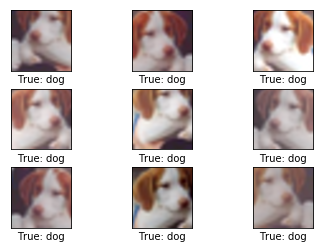

In [54]:
plot_distorted_image(img, cls)

## Perform optimization

In [55]:
writer = tf.summary.FileWriter('logs', sess.graph)
writer.close()

# if False:
optimize(num_iterations=1000)

 25%|██▌       | 251/1000 [00:21<01:01, 12.17it/s]

Global Step:    250, Training Batch Accuracy:   7.8%


 50%|█████     | 501/1000 [00:40<00:39, 12.51it/s]

Global Step:    500, Training Batch Accuracy:  12.5%


 75%|███████▌  | 751/1000 [01:00<00:20, 11.95it/s]

Global Step:    750, Training Batch Accuracy:  20.3%


100%|█████████▉| 999/1000 [01:20<00:00, 12.88it/s]

Global Step:   1000, Training Batch Accuracy:  28.1%


100%|██████████| 1000/1000 [01:22<00:00, 12.12it/s]

Saved checkpoint.
Time usage: 0:01:22


## Results

Examples of mis-classifications are plotted below. Some of these are difficult to recognize even for humans and others are reasonable mistakes e.g. between a large car and a truck, or between a cat and a dog, while other mistakes seem a bit strange.

Accuracy on Test-Set: 27.7% (2767 / 10000), loss on Test-Set: 1.9630
Example errors:


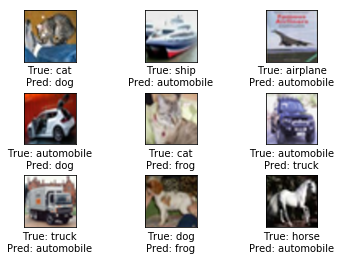

Confusion Matrix:
[411 118   2   2   0  52  58  57  81 219] (0) airplane
[ 27 441   2   0   0  44 134  92  67 193] (1) automobile
[ 93  95   6   8   0  88 492 113  27  78] (2) bird
[ 24  77   3   3   0 174 507 122  17  73] (3) cat
[ 31  31   4   3   0  60 686  83  14  88] (4) deer
[ 20  82   5   6   0 238 477  95  20  57] (5) dog
[  7  39   3   4   0  32 796  82   0  37] (6) frog
[ 19 127   3   6   0  76 346 252   8 163] (7) horse
[164 157   2   1   0  79  41  41 173 342] (8) ship
[ 23 186   2   0   0  29 147 109  57 447] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [56]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

### Convolutional Weights

The following shows some of the weights (or filters) for the first convolutional layer. There are 3 input channels so there are 3 of these sets, which you may plot by changing the `input_channel`.

Note that positive weights are red and negative weights are blue.

Min:  -0.04824, Max:   0.02892
Mean: -0.00911, Stdev: 0.01344


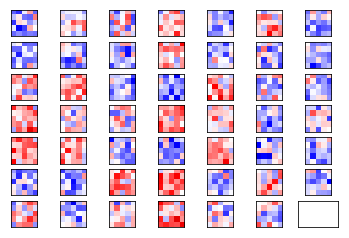

In [57]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

Plot some of the weights (or filters) for the second convolutional layer. These are apparently closer to zero than the weights for the first convolutional layers, see the lower standard deviation.

Min:  -0.04081, Max:   0.03216
Mean: -0.00167, Stdev: 0.00989


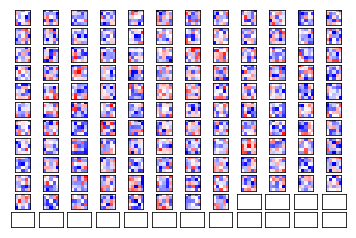

In [58]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

### Output of convolutional layers

Helper-function for plotting an image.

In [59]:
def plot_image(image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 2)

    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # Show raw and smoothened images in sub-plots.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # Set labels.
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Plot an image from the test-set. The raw pixelated image is used as input to the neural network.

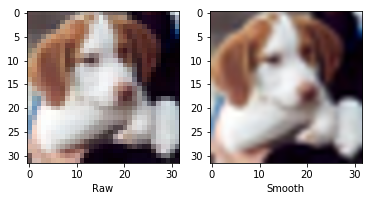

In [60]:
img, cls = get_test_image(16)
plot_image(img)

Use the raw image as input to the neural network and plot the output of the first convolutional layer.

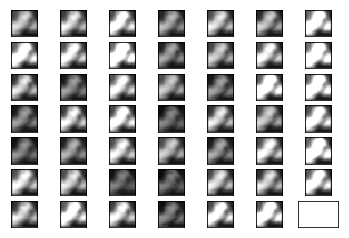

In [61]:
plot_layer_output(output_conv1, image=img)

Using the same image as input to the neural network, now plot the output of the second convolutional layer.

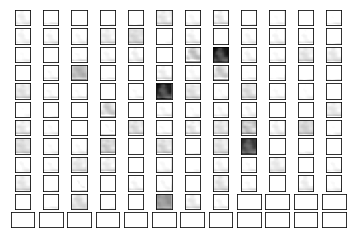

In [62]:
plot_layer_output(output_conv2, image=img)

### Predicted class-labels

Get the predicted class-label and class-number for this image.

In [63]:
label_pred, cls_pred = session.run([y_pred, y_pred_cls],
                                   feed_dict={x: [img], keep_probab: 1.0})

Print the predicted class-label.

In [64]:
# Set the rounding options for numpy.
np.set_printoptions(precision=3, suppress=True)

# Print the predicted label.
print(label_pred[0])

[-0.289  0.154  0.851  1.465  0.586  2.03   1.175  0.222 -0.468 -0.866]


The predicted class-label is an array of length 10, with each element indicating how confident the neural network is that the image is the given class.

In this case the element with index 3 has a value of 0.493, while the element with index 5 has a value of 0.490. This means the neural network believes the image either shows a class 3 or class 5, which is a cat or a dog, respectively.

In [65]:
class_names[2]

'bird'

In [66]:
class_names[6]

'frog'

## Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources.

In [67]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

for i in range(100):
    optimize(num_iterations=5000)
    print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False)

  5%|▌         | 252/5000 [00:19<06:11, 12.79it/s]

Global Step:   1250, Training Batch Accuracy:  35.9%


 10%|█         | 502/5000 [00:38<05:57, 12.58it/s]

Global Step:   1500, Training Batch Accuracy:  28.1%


 15%|█▌        | 752/5000 [00:58<05:37, 12.58it/s]

Global Step:   1750, Training Batch Accuracy:  20.3%


 20%|██        | 1002/5000 [01:17<05:15, 12.67it/s]

Global Step:   2000, Training Batch Accuracy:  31.2%


 25%|██▌       | 1252/5000 [01:36<05:00, 12.49it/s]

Global Step:   2250, Training Batch Accuracy:  29.7%


 30%|███       | 1502/5000 [01:55<04:37, 12.63it/s]

Global Step:   2500, Training Batch Accuracy:  40.6%


 35%|███▌      | 1752/5000 [02:15<04:18, 12.58it/s]

Global Step:   2750, Training Batch Accuracy:  51.6%


 40%|████      | 2002/5000 [02:35<04:11, 11.90it/s]

Global Step:   3000, Training Batch Accuracy:  48.4%


 45%|████▌     | 2252/5000 [02:54<03:52, 11.84it/s]

Global Step:   3250, Training Batch Accuracy:  40.6%


 50%|█████     | 2502/5000 [03:14<03:21, 12.42it/s]

Global Step:   3500, Training Batch Accuracy:  51.6%


 55%|█████▌    | 2752/5000 [03:34<03:11, 11.76it/s]

Global Step:   3750, Training Batch Accuracy:  35.9%


 60%|██████    | 3002/5000 [03:54<02:43, 12.25it/s]

Global Step:   4000, Training Batch Accuracy:  50.0%


 65%|██████▌   | 3252/5000 [04:14<02:18, 12.63it/s]

Global Step:   4250, Training Batch Accuracy:  39.1%


 70%|███████   | 3502/5000 [04:34<01:57, 12.70it/s]

Global Step:   4500, Training Batch Accuracy:  29.7%


 75%|███████▌  | 3752/5000 [04:53<01:38, 12.64it/s]

Global Step:   4750, Training Batch Accuracy:  51.6%


 80%|████████  | 4002/5000 [05:12<01:19, 12.60it/s]

Global Step:   5000, Training Batch Accuracy:  51.6%


 85%|████████▌ | 4252/5000 [05:32<01:02, 12.06it/s]

Global Step:   5250, Training Batch Accuracy:  50.0%


 90%|█████████ | 4502/5000 [05:53<00:41, 12.14it/s]

Global Step:   5500, Training Batch Accuracy:  57.8%


 95%|█████████▌| 4752/5000 [06:12<00:19, 12.54it/s]

Global Step:   5750, Training Batch Accuracy:  46.9%


100%|█████████▉| 4998/5000 [06:32<00:00, 12.35it/s]

Global Step:   6000, Training Batch Accuracy:  51.6%


100%|██████████| 5000/5000 [06:34<00:00,  2.51it/s]

Saved checkpoint.
Time usage: 0:06:35



  0%|          | 2/5000 [00:00<06:42, 12.40it/s]

Accuracy on Test-Set: 51.7% (5175 / 10000), loss on Test-Set: 1.3494


  5%|▌         | 252/5000 [00:20<06:19, 12.51it/s]

Global Step:   6250, Training Batch Accuracy:  43.8%


 10%|█         | 502/5000 [00:39<05:53, 12.73it/s]

Global Step:   6500, Training Batch Accuracy:  50.0%


 15%|█▌        | 752/5000 [00:58<05:38, 12.54it/s]

Global Step:   6750, Training Batch Accuracy:  53.1%


 20%|██        | 1002/5000 [01:18<05:19, 12.52it/s]

Global Step:   7000, Training Batch Accuracy:  54.7%


 25%|██▌       | 1252/5000 [01:37<05:00, 12.49it/s]

Global Step:   7250, Training Batch Accuracy:  50.0%


 30%|███       | 1502/5000 [01:57<04:43, 12.36it/s]

Global Step:   7500, Training Batch Accuracy:  43.8%


 35%|███▌      | 1752/5000 [02:17<04:22, 12.38it/s]

Global Step:   7750, Training Batch Accuracy:  45.3%


 40%|████      | 2002/5000 [02:37<04:12, 11.90it/s]

Global Step:   8000, Training Batch Accuracy:  46.9%


 45%|████▌     | 2252/5000 [02:57<03:39, 12.50it/s]

Global Step:   8250, Training Batch Accuracy:  56.2%


 50%|█████     | 2502/5000 [03:16<03:21, 12.38it/s]

Global Step:   8500, Training Batch Accuracy:  43.8%


 55%|█████▌    | 2752/5000 [03:36<03:05, 12.14it/s]

Global Step:   8750, Training Batch Accuracy:  39.1%


 60%|██████    | 3002/5000 [03:57<02:43, 12.19it/s]

Global Step:   9000, Training Batch Accuracy:  50.0%


 65%|██████▌   | 3252/5000 [04:16<02:19, 12.55it/s]

Global Step:   9250, Training Batch Accuracy:  53.1%


 70%|███████   | 3502/5000 [04:36<01:58, 12.61it/s]

Global Step:   9500, Training Batch Accuracy:  57.8%


 75%|███████▌  | 3752/5000 [04:55<01:40, 12.43it/s]

Global Step:   9750, Training Batch Accuracy:  53.1%


 80%|███████▉  | 3998/5000 [05:15<01:20, 12.48it/s]

Global Step:  10000, Training Batch Accuracy:  59.4%


 80%|████████  | 4002/5000 [05:17<04:36,  3.62it/s]

Saved checkpoint.


 85%|████████▌ | 4252/5000 [05:37<00:59, 12.51it/s]

Global Step:  10250, Training Batch Accuracy:  59.4%


 90%|█████████ | 4502/5000 [05:57<00:40, 12.34it/s]

Global Step:  10500, Training Batch Accuracy:  67.2%


 95%|█████████▌| 4752/5000 [06:18<00:20, 12.28it/s]

Global Step:  10750, Training Batch Accuracy:  53.1%


100%|█████████▉| 4998/5000 [06:37<00:00, 12.73it/s]

Global Step:  11000, Training Batch Accuracy:  59.4%


100%|██████████| 5000/5000 [06:39<00:00,  2.57it/s]

Saved checkpoint.
Time usage: 0:06:40



  0%|          | 2/5000 [00:00<06:49, 12.22it/s]

Accuracy on Test-Set: 60.0% (6004 / 10000), loss on Test-Set: 1.1211


  5%|▌         | 252/5000 [00:21<06:34, 12.04it/s]

Global Step:  11250, Training Batch Accuracy:  54.7%


 10%|█         | 502/5000 [00:40<06:00, 12.47it/s]

Global Step:  11500, Training Batch Accuracy:  62.5%


 15%|█▌        | 752/5000 [01:00<05:43, 12.37it/s]

Global Step:  11750, Training Batch Accuracy:  62.5%


 20%|██        | 1002/5000 [01:20<05:24, 12.30it/s]

Global Step:  12000, Training Batch Accuracy:  56.2%


 25%|██▌       | 1252/5000 [01:39<05:07, 12.19it/s]

Global Step:  12250, Training Batch Accuracy:  62.5%


 30%|███       | 1502/5000 [01:59<04:40, 12.45it/s]

Global Step:  12500, Training Batch Accuracy:  62.5%


 35%|███▌      | 1752/5000 [02:19<04:19, 12.50it/s]

Global Step:  12750, Training Batch Accuracy:  60.9%


 40%|████      | 2002/5000 [02:39<04:04, 12.28it/s]

Global Step:  13000, Training Batch Accuracy:  67.2%


 45%|████▌     | 2252/5000 [02:58<03:41, 12.39it/s]

Global Step:  13250, Training Batch Accuracy:  64.1%


 50%|█████     | 2502/5000 [03:18<03:21, 12.40it/s]

Global Step:  13500, Training Batch Accuracy:  75.0%


 55%|█████▌    | 2752/5000 [03:38<03:01, 12.35it/s]

Global Step:  13750, Training Batch Accuracy:  51.6%


 60%|██████    | 3002/5000 [03:57<02:41, 12.34it/s]

Global Step:  14000, Training Batch Accuracy:  73.4%


 65%|██████▌   | 3252/5000 [04:17<02:20, 12.42it/s]

Global Step:  14250, Training Batch Accuracy:  59.4%


 70%|███████   | 3502/5000 [04:37<02:00, 12.42it/s]

Global Step:  14500, Training Batch Accuracy:  53.1%


 75%|███████▌  | 3752/5000 [04:56<01:40, 12.42it/s]

Global Step:  14750, Training Batch Accuracy:  60.9%


 80%|████████  | 4002/5000 [05:17<01:24, 11.75it/s]

Global Step:  15000, Training Batch Accuracy:  67.2%


 85%|████████▌ | 4252/5000 [05:37<01:00, 12.38it/s]

Global Step:  15250, Training Batch Accuracy:  57.8%


 90%|█████████ | 4502/5000 [05:57<00:40, 12.19it/s]

Global Step:  15500, Training Batch Accuracy:  75.0%


 95%|█████████▌| 4752/5000 [06:17<00:20, 12.32it/s]

Global Step:  15750, Training Batch Accuracy:  64.1%


100%|█████████▉| 4998/5000 [06:36<00:00, 12.53it/s]

Global Step:  16000, Training Batch Accuracy:  65.6%


100%|██████████| 5000/5000 [06:38<00:00,  2.89it/s]

Saved checkpoint.
Time usage: 0:06:39



  0%|          | 2/5000 [00:00<06:35, 12.64it/s]

Accuracy on Test-Set: 65.8% (6577 / 10000), loss on Test-Set: 0.9635


  5%|▌         | 252/5000 [00:19<06:19, 12.51it/s]

Global Step:  16250, Training Batch Accuracy:  54.7%


 10%|█         | 502/5000 [00:39<06:07, 12.25it/s]

Global Step:  16500, Training Batch Accuracy:  70.3%


 15%|█▌        | 752/5000 [01:00<05:46, 12.24it/s]

Global Step:  16750, Training Batch Accuracy:  75.0%


 20%|██        | 1002/5000 [01:21<05:41, 11.72it/s]

Global Step:  17000, Training Batch Accuracy:  67.2%


 25%|██▌       | 1252/5000 [01:41<05:03, 12.36it/s]

Global Step:  17250, Training Batch Accuracy:  68.8%


 30%|███       | 1502/5000 [02:01<04:57, 11.76it/s]

Global Step:  17500, Training Batch Accuracy:  56.2%


 35%|███▌      | 1752/5000 [02:21<04:25, 12.22it/s]

Global Step:  17750, Training Batch Accuracy:  67.2%


 40%|████      | 2002/5000 [02:41<04:00, 12.44it/s]

Global Step:  18000, Training Batch Accuracy:  60.9%


 45%|████▌     | 2252/5000 [03:01<03:41, 12.40it/s]

Global Step:  18250, Training Batch Accuracy:  68.8%


 50%|█████     | 2502/5000 [03:20<03:21, 12.42it/s]

Global Step:  18500, Training Batch Accuracy:  70.3%


 55%|█████▌    | 2752/5000 [03:40<03:02, 12.31it/s]

Global Step:  18750, Training Batch Accuracy:  64.1%


 60%|██████    | 3002/5000 [04:00<02:50, 11.72it/s]

Global Step:  19000, Training Batch Accuracy:  68.8%


 65%|██████▌   | 3252/5000 [04:21<02:27, 11.83it/s]

Global Step:  19250, Training Batch Accuracy:  64.1%


 70%|███████   | 3502/5000 [04:41<02:07, 11.72it/s]

Global Step:  19500, Training Batch Accuracy:  62.5%


 75%|███████▌  | 3752/5000 [05:02<01:40, 12.48it/s]

Global Step:  19750, Training Batch Accuracy:  60.9%


 80%|███████▉  | 3998/5000 [05:21<01:20, 12.51it/s]

Global Step:  20000, Training Batch Accuracy:  60.9%


 80%|████████  | 4002/5000 [05:23<04:51,  3.42it/s]

Saved checkpoint.


 85%|████████▌ | 4252/5000 [05:43<01:04, 11.57it/s]

Global Step:  20250, Training Batch Accuracy:  68.8%


 90%|█████████ | 4502/5000 [06:04<00:40, 12.16it/s]

Global Step:  20500, Training Batch Accuracy:  70.3%


 95%|█████████▌| 4752/5000 [06:24<00:21, 11.75it/s]

Global Step:  20750, Training Batch Accuracy:  57.8%


100%|█████████▉| 4998/5000 [06:44<00:00, 12.67it/s]

Global Step:  21000, Training Batch Accuracy:  68.8%


100%|██████████| 5000/5000 [06:46<00:00,  2.84it/s]

Saved checkpoint.
Time usage: 0:06:46



  0%|          | 2/5000 [00:00<06:38, 12.54it/s]

Accuracy on Test-Set: 70.3% (7027 / 10000), loss on Test-Set: 0.8556


  5%|▌         | 252/5000 [00:20<06:30, 12.15it/s]

Global Step:  21250, Training Batch Accuracy:  73.4%


 10%|█         | 502/5000 [00:39<06:07, 12.23it/s]

Global Step:  21500, Training Batch Accuracy:  59.4%


 15%|█▌        | 752/5000 [00:59<05:46, 12.28it/s]

Global Step:  21750, Training Batch Accuracy:  81.2%


 20%|██        | 1002/5000 [01:19<05:29, 12.14it/s]

Global Step:  22000, Training Batch Accuracy:  67.2%


 25%|██▌       | 1252/5000 [01:39<05:01, 12.42it/s]

Global Step:  22250, Training Batch Accuracy:  68.8%


 30%|███       | 1502/5000 [01:59<04:53, 11.91it/s]

Global Step:  22500, Training Batch Accuracy:  70.3%


 35%|███▌      | 1752/5000 [02:19<04:20, 12.47it/s]

Global Step:  22750, Training Batch Accuracy:  59.4%


 40%|████      | 2002/5000 [02:39<04:06, 12.16it/s]

Global Step:  23000, Training Batch Accuracy:  67.2%


 45%|████▌     | 2252/5000 [02:59<03:42, 12.34it/s]

Global Step:  23250, Training Batch Accuracy:  76.6%


 50%|█████     | 2502/5000 [03:19<03:20, 12.44it/s]

Global Step:  23500, Training Batch Accuracy:  65.6%


 55%|█████▌    | 2752/5000 [03:39<03:02, 12.29it/s]

Global Step:  23750, Training Batch Accuracy:  78.1%


 60%|██████    | 3002/5000 [03:58<02:41, 12.35it/s]

Global Step:  24000, Training Batch Accuracy:  65.6%


 65%|██████▌   | 3252/5000 [04:18<02:27, 11.85it/s]

Global Step:  24250, Training Batch Accuracy:  75.0%


 70%|███████   | 3502/5000 [04:38<02:00, 12.45it/s]

Global Step:  24500, Training Batch Accuracy:  75.0%


 75%|███████▌  | 3752/5000 [04:58<01:41, 12.34it/s]

Global Step:  24750, Training Batch Accuracy:  73.4%


 80%|████████  | 4002/5000 [05:17<01:20, 12.43it/s]

Global Step:  25000, Training Batch Accuracy:  71.9%


 85%|████████▌ | 4252/5000 [05:37<01:00, 12.44it/s]

Global Step:  25250, Training Batch Accuracy:  70.3%


 90%|█████████ | 4502/5000 [05:56<00:40, 12.28it/s]

Global Step:  25500, Training Batch Accuracy:  85.9%


 95%|█████████▌| 4752/5000 [06:16<00:19, 12.40it/s]

Global Step:  25750, Training Batch Accuracy:  82.8%


100%|█████████▉| 4998/5000 [06:35<00:00, 12.50it/s]

Global Step:  26000, Training Batch Accuracy:  79.7%


100%|██████████| 5000/5000 [06:38<00:00,  2.57it/s]

Saved checkpoint.
Time usage: 0:06:38



  0%|          | 2/5000 [00:00<06:23, 13.03it/s]

Accuracy on Test-Set: 72.1% (7209 / 10000), loss on Test-Set: 0.7972


  5%|▌         | 252/5000 [00:19<06:26, 12.29it/s]

Global Step:  26250, Training Batch Accuracy:  78.1%


 10%|█         | 502/5000 [00:39<06:02, 12.40it/s]

Global Step:  26500, Training Batch Accuracy:  85.9%


 15%|█▌        | 752/5000 [00:59<05:40, 12.46it/s]

Global Step:  26750, Training Batch Accuracy:  81.2%


 20%|██        | 1002/5000 [01:18<05:25, 12.29it/s]

Global Step:  27000, Training Batch Accuracy:  71.9%


 25%|██▌       | 1252/5000 [01:38<05:03, 12.37it/s]

Global Step:  27250, Training Batch Accuracy:  71.9%


 30%|███       | 1502/5000 [01:57<04:42, 12.39it/s]

Global Step:  27500, Training Batch Accuracy:  65.6%


 35%|███▌      | 1752/5000 [02:17<04:24, 12.27it/s]

Global Step:  27750, Training Batch Accuracy:  84.4%


 40%|████      | 2002/5000 [02:37<04:03, 12.32it/s]

Global Step:  28000, Training Batch Accuracy:  67.2%


 45%|████▌     | 2252/5000 [02:56<03:44, 12.22it/s]

Global Step:  28250, Training Batch Accuracy:  73.4%


 50%|█████     | 2502/5000 [03:16<03:22, 12.33it/s]

Global Step:  28500, Training Batch Accuracy:  68.8%


 55%|█████▌    | 2752/5000 [03:36<02:59, 12.51it/s]

Global Step:  28750, Training Batch Accuracy:  75.0%


 60%|██████    | 3002/5000 [03:55<02:41, 12.40it/s]

Global Step:  29000, Training Batch Accuracy:  75.0%


 65%|██████▌   | 3252/5000 [04:15<02:21, 12.35it/s]

Global Step:  29250, Training Batch Accuracy:  70.3%


 70%|███████   | 3502/5000 [04:35<02:00, 12.42it/s]

Global Step:  29500, Training Batch Accuracy:  67.2%


 75%|███████▌  | 3752/5000 [04:54<01:45, 11.78it/s]

Global Step:  29750, Training Batch Accuracy:  64.1%


 80%|███████▉  | 3998/5000 [05:14<01:19, 12.68it/s]

Global Step:  30000, Training Batch Accuracy:  79.7%


 80%|████████  | 4002/5000 [05:16<04:28,  3.71it/s]

Saved checkpoint.


 85%|████████▌ | 4252/5000 [05:36<01:00, 12.45it/s]

Global Step:  30250, Training Batch Accuracy:  73.4%


 90%|█████████ | 4502/5000 [05:55<00:40, 12.45it/s]

Global Step:  30500, Training Batch Accuracy:  73.4%


 95%|█████████▌| 4752/5000 [06:15<00:19, 12.44it/s]

Global Step:  30750, Training Batch Accuracy:  76.6%


100%|█████████▉| 4998/5000 [06:34<00:00, 12.64it/s]

Global Step:  31000, Training Batch Accuracy:  79.7%


100%|██████████| 5000/5000 [06:37<00:00,  2.58it/s]

Saved checkpoint.
Time usage: 0:06:37



  0%|          | 2/5000 [00:00<06:33, 12.71it/s]

Accuracy on Test-Set: 74.1% (7408 / 10000), loss on Test-Set: 0.7369


  5%|▌         | 252/5000 [00:20<06:19, 12.51it/s]

Global Step:  31250, Training Batch Accuracy:  79.7%


 10%|█         | 502/5000 [00:39<06:02, 12.41it/s]

Global Step:  31500, Training Batch Accuracy:  70.3%


 15%|█▌        | 752/5000 [00:59<05:55, 11.95it/s]

Global Step:  31750, Training Batch Accuracy:  79.7%


 20%|██        | 1002/5000 [01:19<05:23, 12.35it/s]

Global Step:  32000, Training Batch Accuracy:  76.6%


 25%|██▌       | 1252/5000 [01:39<05:01, 12.44it/s]

Global Step:  32250, Training Batch Accuracy:  78.1%


 30%|███       | 1502/5000 [01:59<04:42, 12.37it/s]

Global Step:  32500, Training Batch Accuracy:  84.4%


 35%|███▌      | 1752/5000 [02:18<04:26, 12.21it/s]

Global Step:  32750, Training Batch Accuracy:  76.6%


 40%|████      | 2002/5000 [02:38<04:05, 12.23it/s]

Global Step:  33000, Training Batch Accuracy:  70.3%


 45%|████▌     | 2252/5000 [02:58<03:43, 12.29it/s]

Global Step:  33250, Training Batch Accuracy:  71.9%


 50%|█████     | 2502/5000 [03:18<03:24, 12.21it/s]

Global Step:  33500, Training Batch Accuracy:  78.1%


 55%|█████▌    | 2752/5000 [03:38<03:03, 12.22it/s]

Global Step:  33750, Training Batch Accuracy:  67.2%


 60%|██████    | 3002/5000 [03:58<02:47, 11.95it/s]

Global Step:  34000, Training Batch Accuracy:  81.2%


 65%|██████▌   | 3252/5000 [04:18<02:23, 12.19it/s]

Global Step:  34250, Training Batch Accuracy:  81.2%


 70%|███████   | 3502/5000 [04:38<02:00, 12.42it/s]

Global Step:  34500, Training Batch Accuracy:  79.7%


 75%|███████▌  | 3752/5000 [04:58<01:44, 11.95it/s]

Global Step:  34750, Training Batch Accuracy:  76.6%


 80%|████████  | 4002/5000 [05:18<01:22, 12.15it/s]

Global Step:  35000, Training Batch Accuracy:  75.0%


 85%|████████▌ | 4252/5000 [05:38<01:04, 11.53it/s]

Global Step:  35250, Training Batch Accuracy:  85.9%


 90%|█████████ | 4502/5000 [05:59<00:41, 11.90it/s]

Global Step:  35500, Training Batch Accuracy:  79.7%


 95%|█████████▌| 4752/5000 [06:19<00:20, 12.09it/s]

Global Step:  35750, Training Batch Accuracy:  76.6%


100%|█████████▉| 4998/5000 [06:39<00:00, 12.60it/s]

Global Step:  36000, Training Batch Accuracy:  71.9%


100%|██████████| 5000/5000 [06:41<00:00,  2.83it/s]

Saved checkpoint.
Time usage: 0:06:41



  0%|          | 2/5000 [00:00<06:32, 12.74it/s]

Accuracy on Test-Set: 74.6% (7458 / 10000), loss on Test-Set: 0.7203


  5%|▌         | 252/5000 [00:20<06:28, 12.21it/s]

Global Step:  36250, Training Batch Accuracy:  75.0%


 10%|█         | 502/5000 [00:40<06:14, 12.02it/s]

Global Step:  36500, Training Batch Accuracy:  84.4%


 15%|█▌        | 752/5000 [01:00<05:46, 12.27it/s]

Global Step:  36750, Training Batch Accuracy:  75.0%


 20%|██        | 1002/5000 [01:20<05:21, 12.44it/s]

Global Step:  37000, Training Batch Accuracy:  71.9%


 25%|██▌       | 1252/5000 [01:40<05:18, 11.78it/s]

Global Step:  37250, Training Batch Accuracy:  78.1%


 30%|███       | 1502/5000 [02:00<04:55, 11.82it/s]

Global Step:  37500, Training Batch Accuracy:  76.6%


 35%|███▌      | 1752/5000 [02:20<04:42, 11.51it/s]

Global Step:  37750, Training Batch Accuracy:  79.7%


 40%|████      | 2002/5000 [02:41<03:59, 12.50it/s]

Global Step:  38000, Training Batch Accuracy:  73.4%


 45%|████▌     | 2252/5000 [03:01<03:55, 11.66it/s]

Global Step:  38250, Training Batch Accuracy:  75.0%


 50%|█████     | 2502/5000 [03:22<03:24, 12.21it/s]

Global Step:  38500, Training Batch Accuracy:  82.8%


 55%|█████▌    | 2752/5000 [03:41<03:02, 12.34it/s]

Global Step:  38750, Training Batch Accuracy:  78.1%


 60%|██████    | 3002/5000 [04:02<02:53, 11.52it/s]

Global Step:  39000, Training Batch Accuracy:  68.8%


 65%|██████▌   | 3252/5000 [04:22<02:22, 12.28it/s]

Global Step:  39250, Training Batch Accuracy:  81.2%


 70%|███████   | 3502/5000 [04:42<02:01, 12.30it/s]

Global Step:  39500, Training Batch Accuracy:  78.1%


 75%|███████▌  | 3752/5000 [05:02<01:45, 11.83it/s]

Global Step:  39750, Training Batch Accuracy:  70.3%


 80%|███████▉  | 3998/5000 [05:22<01:23, 12.05it/s]

Global Step:  40000, Training Batch Accuracy:  73.4%


 80%|████████  | 4002/5000 [05:24<04:57,  3.36it/s]

Saved checkpoint.


 85%|████████▌ | 4252/5000 [05:45<01:03, 11.70it/s]

Global Step:  40250, Training Batch Accuracy:  81.2%


 90%|█████████ | 4502/5000 [06:05<00:40, 12.35it/s]

Global Step:  40500, Training Batch Accuracy:  81.2%


 95%|█████████▌| 4752/5000 [06:25<00:20, 12.07it/s]

Global Step:  40750, Training Batch Accuracy:  76.6%


100%|█████████▉| 4998/5000 [06:45<00:00, 12.81it/s]

Global Step:  41000, Training Batch Accuracy:  76.6%


100%|██████████| 5000/5000 [06:47<00:00,  2.83it/s]

Saved checkpoint.
Time usage: 0:06:47



  0%|          | 2/5000 [00:00<06:38, 12.53it/s]

Accuracy on Test-Set: 76.3% (7635 / 10000), loss on Test-Set: 0.6795


  5%|▌         | 252/5000 [00:19<06:23, 12.37it/s]

Global Step:  41250, Training Batch Accuracy:  87.5%


 10%|█         | 502/5000 [00:39<06:07, 12.24it/s]

Global Step:  41500, Training Batch Accuracy:  84.4%


 15%|█▌        | 752/5000 [00:59<06:06, 11.59it/s]

Global Step:  41750, Training Batch Accuracy:  76.6%


 20%|██        | 1002/5000 [01:19<05:25, 12.27it/s]

Global Step:  42000, Training Batch Accuracy:  75.0%


 25%|██▌       | 1252/5000 [01:39<05:02, 12.39it/s]

Global Step:  42250, Training Batch Accuracy:  84.4%


 30%|███       | 1502/5000 [01:59<04:47, 12.19it/s]

Global Step:  42500, Training Batch Accuracy:  78.1%


 35%|███▌      | 1752/5000 [02:19<04:24, 12.27it/s]

Global Step:  42750, Training Batch Accuracy:  79.7%


 40%|████      | 2002/5000 [02:38<04:05, 12.22it/s]

Global Step:  43000, Training Batch Accuracy:  82.8%


 45%|████▌     | 2252/5000 [02:58<03:42, 12.37it/s]

Global Step:  43250, Training Batch Accuracy:  78.1%


 50%|█████     | 2502/5000 [03:18<03:23, 12.29it/s]

Global Step:  43500, Training Batch Accuracy:  76.6%


 55%|█████▌    | 2752/5000 [03:38<03:01, 12.40it/s]

Global Step:  43750, Training Batch Accuracy:  79.7%


 60%|██████    | 3002/5000 [03:58<02:48, 11.88it/s]

Global Step:  44000, Training Batch Accuracy:  73.4%


 65%|██████▌   | 3252/5000 [04:18<02:23, 12.22it/s]

Global Step:  44250, Training Batch Accuracy:  79.7%


 70%|███████   | 3502/5000 [04:37<02:00, 12.40it/s]

Global Step:  44500, Training Batch Accuracy:  85.9%


 75%|███████▌  | 3752/5000 [04:57<01:41, 12.25it/s]

Global Step:  44750, Training Batch Accuracy:  85.9%


 80%|████████  | 4002/5000 [05:17<01:20, 12.46it/s]

Global Step:  45000, Training Batch Accuracy:  81.2%


 85%|████████▌ | 4252/5000 [05:36<00:59, 12.48it/s]

Global Step:  45250, Training Batch Accuracy:  90.6%


 90%|█████████ | 4502/5000 [05:57<00:41, 12.09it/s]

Global Step:  45500, Training Batch Accuracy:  68.8%


 95%|█████████▌| 4752/5000 [06:16<00:20, 12.24it/s]

Global Step:  45750, Training Batch Accuracy:  81.2%


100%|█████████▉| 4998/5000 [06:36<00:00, 12.79it/s]

Global Step:  46000, Training Batch Accuracy:  78.1%


100%|██████████| 5000/5000 [06:38<00:00,  2.60it/s]

Saved checkpoint.
Time usage: 0:06:38



  0%|          | 2/5000 [00:00<06:46, 12.30it/s]

Accuracy on Test-Set: 77.6% (7763 / 10000), loss on Test-Set: 0.6449


  5%|▌         | 252/5000 [00:20<06:44, 11.74it/s]

Global Step:  46250, Training Batch Accuracy:  82.8%


 10%|█         | 502/5000 [00:40<06:05, 12.29it/s]

Global Step:  46500, Training Batch Accuracy:  68.8%


 15%|█▌        | 752/5000 [01:00<05:47, 12.24it/s]

Global Step:  46750, Training Batch Accuracy:  79.7%


 20%|██        | 1002/5000 [01:20<05:22, 12.40it/s]

Global Step:  47000, Training Batch Accuracy:  81.2%


 25%|██▌       | 1252/5000 [01:39<05:04, 12.32it/s]

Global Step:  47250, Training Batch Accuracy:  70.3%


 30%|███       | 1502/5000 [01:59<04:40, 12.49it/s]

Global Step:  47500, Training Batch Accuracy:  84.4%


 35%|███▌      | 1752/5000 [02:19<04:22, 12.38it/s]

Global Step:  47750, Training Batch Accuracy:  75.0%


 40%|████      | 2002/5000 [02:39<04:05, 12.24it/s]

Global Step:  48000, Training Batch Accuracy:  71.9%


 45%|████▌     | 2252/5000 [02:59<03:41, 12.43it/s]

Global Step:  48250, Training Batch Accuracy:  92.2%


 50%|█████     | 2502/5000 [03:18<03:20, 12.49it/s]

Global Step:  48500, Training Batch Accuracy:  81.2%


 55%|█████▌    | 2752/5000 [03:38<03:00, 12.43it/s]

Global Step:  48750, Training Batch Accuracy:  84.4%


 60%|██████    | 3002/5000 [03:58<02:48, 11.83it/s]

Global Step:  49000, Training Batch Accuracy:  79.7%


 65%|██████▌   | 3252/5000 [04:18<02:20, 12.47it/s]

Global Step:  49250, Training Batch Accuracy:  82.8%


 70%|███████   | 3502/5000 [04:38<02:02, 12.19it/s]

Global Step:  49500, Training Batch Accuracy:  76.6%


 75%|███████▌  | 3752/5000 [04:57<01:41, 12.27it/s]

Global Step:  49750, Training Batch Accuracy:  87.5%


 80%|███████▉  | 3998/5000 [05:17<01:18, 12.70it/s]

Global Step:  50000, Training Batch Accuracy:  78.1%


 80%|████████  | 4002/5000 [05:19<04:30,  3.70it/s]

Saved checkpoint.


 85%|████████▌ | 4252/5000 [05:39<01:00, 12.27it/s]

Global Step:  50250, Training Batch Accuracy:  85.9%


 90%|█████████ | 4502/5000 [05:58<00:39, 12.46it/s]

Global Step:  50500, Training Batch Accuracy:  73.4%


 95%|█████████▌| 4752/5000 [06:18<00:20, 12.28it/s]

Global Step:  50750, Training Batch Accuracy:  73.4%


100%|█████████▉| 4998/5000 [06:37<00:00, 12.14it/s]

Global Step:  51000, Training Batch Accuracy:  78.1%


100%|██████████| 5000/5000 [06:40<00:00,  2.54it/s]

Saved checkpoint.
Time usage: 0:06:40



  0%|          | 2/5000 [00:00<06:59, 11.91it/s]

Accuracy on Test-Set: 79.1% (7914 / 10000), loss on Test-Set: 0.5987


  5%|▌         | 252/5000 [00:20<06:28, 12.21it/s]

Global Step:  51250, Training Batch Accuracy:  81.2%


 10%|█         | 502/5000 [00:39<06:05, 12.30it/s]

Global Step:  51500, Training Batch Accuracy:  79.7%


 15%|█▌        | 752/5000 [00:59<05:46, 12.25it/s]

Global Step:  51750, Training Batch Accuracy:  78.1%


 20%|██        | 1002/5000 [01:19<05:20, 12.48it/s]

Global Step:  52000, Training Batch Accuracy:  81.2%


 25%|██▌       | 1252/5000 [01:39<05:10, 12.07it/s]

Global Step:  52250, Training Batch Accuracy:  82.8%


 30%|███       | 1502/5000 [02:00<04:45, 12.24it/s]

Global Step:  52500, Training Batch Accuracy:  84.4%


 35%|███▌      | 1752/5000 [02:20<04:23, 12.34it/s]

Global Step:  52750, Training Batch Accuracy:  85.9%


 40%|████      | 2002/5000 [02:40<04:11, 11.93it/s]

Global Step:  53000, Training Batch Accuracy:  76.6%


 45%|████▌     | 2252/5000 [02:59<03:40, 12.44it/s]

Global Step:  53250, Training Batch Accuracy:  76.6%


 50%|█████     | 2502/5000 [03:19<03:21, 12.40it/s]

Global Step:  53500, Training Batch Accuracy:  89.1%


 55%|█████▌    | 2752/5000 [03:39<02:59, 12.51it/s]

Global Step:  53750, Training Batch Accuracy:  82.8%


 60%|██████    | 3002/5000 [03:59<02:41, 12.37it/s]

Global Step:  54000, Training Batch Accuracy:  81.2%


 65%|██████▌   | 3252/5000 [04:19<02:22, 12.27it/s]

Global Step:  54250, Training Batch Accuracy:  78.1%


 70%|███████   | 3502/5000 [04:39<02:00, 12.43it/s]

Global Step:  54500, Training Batch Accuracy:  82.8%


 75%|███████▌  | 3752/5000 [04:58<01:40, 12.47it/s]

Global Step:  54750, Training Batch Accuracy:  87.5%


 80%|████████  | 4002/5000 [05:18<01:20, 12.40it/s]

Global Step:  55000, Training Batch Accuracy:  76.6%


 85%|████████▌ | 4252/5000 [05:38<01:00, 12.30it/s]

Global Step:  55250, Training Batch Accuracy:  71.9%


 90%|█████████ | 4502/5000 [05:58<00:40, 12.35it/s]

Global Step:  55500, Training Batch Accuracy:  73.4%


 95%|█████████▌| 4752/5000 [06:17<00:20, 12.34it/s]

Global Step:  55750, Training Batch Accuracy:  71.9%


100%|█████████▉| 4998/5000 [06:37<00:00, 12.67it/s]

Global Step:  56000, Training Batch Accuracy:  90.6%


100%|██████████| 5000/5000 [06:39<00:00,  2.85it/s]

Saved checkpoint.
Time usage: 0:06:39



  0%|          | 2/5000 [00:00<06:51, 12.15it/s]

Accuracy on Test-Set: 80.4% (8044 / 10000), loss on Test-Set: 0.5757


  5%|▌         | 252/5000 [00:20<06:26, 12.29it/s]

Global Step:  56250, Training Batch Accuracy:  89.1%


 10%|█         | 502/5000 [00:39<06:06, 12.29it/s]

Global Step:  56500, Training Batch Accuracy:  85.9%


 15%|█▌        | 752/5000 [00:59<05:50, 12.12it/s]

Global Step:  56750, Training Batch Accuracy:  78.1%


 20%|██        | 1002/5000 [01:19<05:27, 12.20it/s]

Global Step:  57000, Training Batch Accuracy:  78.1%


 25%|██▌       | 1252/5000 [01:39<05:05, 12.28it/s]

Global Step:  57250, Training Batch Accuracy:  84.4%


 30%|███       | 1502/5000 [01:58<04:43, 12.36it/s]

Global Step:  57500, Training Batch Accuracy:  81.2%


 35%|███▌      | 1752/5000 [02:18<04:25, 12.24it/s]

Global Step:  57750, Training Batch Accuracy:  89.1%


 40%|████      | 2002/5000 [02:38<04:11, 11.93it/s]

Global Step:  58000, Training Batch Accuracy:  79.7%


 45%|████▌     | 2252/5000 [02:58<03:41, 12.43it/s]

Global Step:  58250, Training Batch Accuracy:  85.9%


 50%|█████     | 2502/5000 [03:18<03:19, 12.50it/s]

Global Step:  58500, Training Batch Accuracy:  79.7%


 55%|█████▌    | 2752/5000 [03:38<02:59, 12.55it/s]

Global Step:  58750, Training Batch Accuracy:  78.1%


 60%|██████    | 3002/5000 [03:57<02:40, 12.44it/s]

Global Step:  59000, Training Batch Accuracy:  73.4%


 65%|██████▌   | 3252/5000 [04:17<02:20, 12.49it/s]

Global Step:  59250, Training Batch Accuracy:  82.8%


 70%|███████   | 3502/5000 [04:36<02:00, 12.44it/s]

Global Step:  59500, Training Batch Accuracy:  81.2%


 75%|███████▌  | 3752/5000 [04:56<01:41, 12.32it/s]

Global Step:  59750, Training Batch Accuracy:  85.9%


 80%|███████▉  | 3998/5000 [05:15<01:19, 12.59it/s]

Global Step:  60000, Training Batch Accuracy:  82.8%


 80%|████████  | 4002/5000 [05:17<04:49,  3.44it/s]

Saved checkpoint.


 85%|████████▌ | 4252/5000 [05:37<01:00, 12.42it/s]

Global Step:  60250, Training Batch Accuracy:  81.2%


 90%|█████████ | 4502/5000 [05:57<00:40, 12.42it/s]

Global Step:  60500, Training Batch Accuracy:  81.2%


 95%|█████████▌| 4752/5000 [06:16<00:19, 12.51it/s]

Global Step:  60750, Training Batch Accuracy:  87.5%


100%|█████████▉| 4998/5000 [06:36<00:00, 12.83it/s]

Global Step:  61000, Training Batch Accuracy:  79.7%


100%|██████████| 5000/5000 [06:38<00:00,  2.83it/s]

Saved checkpoint.
Time usage: 0:06:38



  0%|          | 2/5000 [00:00<06:15, 13.30it/s]

Accuracy on Test-Set: 80.3% (8028 / 10000), loss on Test-Set: 0.5671


  5%|▌         | 252/5000 [00:19<06:21, 12.44it/s]

Global Step:  61250, Training Batch Accuracy:  73.4%


 10%|█         | 502/5000 [00:39<06:01, 12.43it/s]

Global Step:  61500, Training Batch Accuracy:  89.1%


 15%|█▌        | 752/5000 [00:58<05:48, 12.20it/s]

Global Step:  61750, Training Batch Accuracy:  85.9%


 20%|██        | 1002/5000 [01:18<05:21, 12.44it/s]

Global Step:  62000, Training Batch Accuracy:  85.9%


 25%|██▌       | 1252/5000 [01:38<05:02, 12.40it/s]

Global Step:  62250, Training Batch Accuracy:  78.1%


 30%|███       | 1502/5000 [01:57<04:40, 12.45it/s]

Global Step:  62500, Training Batch Accuracy:  81.2%


 35%|███▌      | 1752/5000 [02:17<04:23, 12.35it/s]

Global Step:  62750, Training Batch Accuracy:  87.5%


 40%|████      | 2002/5000 [02:36<03:59, 12.53it/s]

Global Step:  63000, Training Batch Accuracy:  84.4%


 45%|████▌     | 2252/5000 [02:56<03:39, 12.50it/s]

Global Step:  63250, Training Batch Accuracy:  85.9%


 50%|█████     | 2502/5000 [03:16<03:21, 12.39it/s]

Global Step:  63500, Training Batch Accuracy:  78.1%


 55%|█████▌    | 2752/5000 [03:35<03:02, 12.29it/s]

Global Step:  63750, Training Batch Accuracy:  87.5%


 60%|██████    | 3002/5000 [03:55<02:41, 12.40it/s]

Global Step:  64000, Training Batch Accuracy:  87.5%


 65%|██████▌   | 3252/5000 [04:14<02:20, 12.40it/s]

Global Step:  64250, Training Batch Accuracy:  82.8%


 70%|███████   | 3502/5000 [04:34<02:02, 12.22it/s]

Global Step:  64500, Training Batch Accuracy:  92.2%


 75%|███████▌  | 3752/5000 [04:54<01:42, 12.20it/s]

Global Step:  64750, Training Batch Accuracy:  87.5%


 80%|████████  | 4002/5000 [05:13<01:20, 12.43it/s]

Global Step:  65000, Training Batch Accuracy:  79.7%


 85%|████████▌ | 4252/5000 [05:34<01:00, 12.39it/s]

Global Step:  65250, Training Batch Accuracy:  84.4%


 90%|█████████ | 4502/5000 [05:53<00:39, 12.51it/s]

Global Step:  65500, Training Batch Accuracy:  82.8%


 95%|█████████▌| 4752/5000 [06:13<00:19, 12.43it/s]

Global Step:  65750, Training Batch Accuracy:  84.4%


100%|█████████▉| 4998/5000 [06:32<00:00, 12.91it/s]

Global Step:  66000, Training Batch Accuracy:  85.9%


100%|██████████| 5000/5000 [06:35<00:00,  2.60it/s]

Saved checkpoint.
Time usage: 0:06:35



  0%|          | 2/5000 [00:00<06:32, 12.73it/s]

Accuracy on Test-Set: 81.4% (8137 / 10000), loss on Test-Set: 0.5426


  5%|▌         | 252/5000 [00:19<06:21, 12.45it/s]

Global Step:  66250, Training Batch Accuracy:  85.9%


 10%|█         | 502/5000 [00:39<06:01, 12.43it/s]

Global Step:  66500, Training Batch Accuracy:  79.7%


 15%|█▌        | 752/5000 [00:59<05:39, 12.53it/s]

Global Step:  66750, Training Batch Accuracy:  81.2%


 20%|██        | 1002/5000 [01:18<05:21, 12.44it/s]

Global Step:  67000, Training Batch Accuracy:  84.4%


 25%|██▌       | 1252/5000 [01:38<05:06, 12.25it/s]

Global Step:  67250, Training Batch Accuracy:  87.5%


 30%|███       | 1502/5000 [01:58<04:44, 12.30it/s]

Global Step:  67500, Training Batch Accuracy:  79.7%


 35%|███▌      | 1752/5000 [02:17<04:22, 12.36it/s]

Global Step:  67750, Training Batch Accuracy:  85.9%


 40%|████      | 2002/5000 [02:37<04:01, 12.40it/s]

Global Step:  68000, Training Batch Accuracy:  79.7%


 45%|████▌     | 2252/5000 [02:57<03:41, 12.38it/s]

Global Step:  68250, Training Batch Accuracy:  81.2%


 50%|█████     | 2502/5000 [03:16<03:21, 12.42it/s]

Global Step:  68500, Training Batch Accuracy:  81.2%


 55%|█████▌    | 2752/5000 [03:36<03:01, 12.41it/s]

Global Step:  68750, Training Batch Accuracy:  89.1%


 60%|██████    | 3002/5000 [03:56<02:41, 12.38it/s]

Global Step:  69000, Training Batch Accuracy:  81.2%


 65%|██████▌   | 3252/5000 [04:15<02:20, 12.47it/s]

Global Step:  69250, Training Batch Accuracy:  89.1%


 70%|███████   | 3502/5000 [04:35<01:59, 12.50it/s]

Global Step:  69500, Training Batch Accuracy:  87.5%


 75%|███████▌  | 3752/5000 [04:55<01:40, 12.46it/s]

Global Step:  69750, Training Batch Accuracy:  89.1%


 80%|███████▉  | 3998/5000 [05:14<01:17, 12.85it/s]

Global Step:  70000, Training Batch Accuracy:  79.7%


 80%|████████  | 4002/5000 [05:16<04:29,  3.70it/s]

Saved checkpoint.


 85%|████████▌ | 4252/5000 [05:36<00:59, 12.51it/s]

Global Step:  70250, Training Batch Accuracy:  84.4%


 90%|█████████ | 4502/5000 [05:55<00:40, 12.40it/s]

Global Step:  70500, Training Batch Accuracy:  79.7%


 95%|█████████▌| 4752/5000 [06:15<00:19, 12.43it/s]

Global Step:  70750, Training Batch Accuracy:  84.4%


100%|█████████▉| 4998/5000 [06:34<00:00, 12.78it/s]

Global Step:  71000, Training Batch Accuracy:  85.9%


100%|██████████| 5000/5000 [06:36<00:00,  2.60it/s]

Saved checkpoint.
Time usage: 0:06:37



  0%|          | 2/5000 [00:00<06:38, 12.53it/s]

Accuracy on Test-Set: 82.2% (8220 / 10000), loss on Test-Set: 0.5173


  5%|▌         | 252/5000 [00:20<06:30, 12.15it/s]

Global Step:  71250, Training Batch Accuracy:  84.4%


 10%|█         | 502/5000 [00:39<06:02, 12.40it/s]

Global Step:  71500, Training Batch Accuracy:  84.4%


 15%|█▌        | 752/5000 [00:59<05:41, 12.45it/s]

Global Step:  71750, Training Batch Accuracy:  89.1%


 20%|██        | 1002/5000 [01:18<05:21, 12.42it/s]

Global Step:  72000, Training Batch Accuracy:  85.9%


 25%|██▌       | 1252/5000 [01:38<05:02, 12.39it/s]

Global Step:  72250, Training Batch Accuracy:  84.4%


 30%|███       | 1502/5000 [01:58<04:41, 12.42it/s]

Global Step:  72500, Training Batch Accuracy:  84.4%


 35%|███▌      | 1752/5000 [02:17<04:19, 12.52it/s]

Global Step:  72750, Training Batch Accuracy:  84.4%


 40%|████      | 2002/5000 [02:37<04:00, 12.46it/s]

Global Step:  73000, Training Batch Accuracy:  84.4%


 45%|████▌     | 2252/5000 [02:56<03:40, 12.47it/s]

Global Step:  73250, Training Batch Accuracy:  92.2%


 50%|█████     | 2502/5000 [03:16<03:21, 12.40it/s]

Global Step:  73500, Training Batch Accuracy:  78.1%


 55%|█████▌    | 2752/5000 [03:36<03:03, 12.28it/s]

Global Step:  73750, Training Batch Accuracy:  85.9%


 60%|██████    | 3002/5000 [03:55<02:39, 12.52it/s]

Global Step:  74000, Training Batch Accuracy:  82.8%


 65%|██████▌   | 3252/5000 [04:15<02:21, 12.35it/s]

Global Step:  74250, Training Batch Accuracy:  89.1%


 70%|███████   | 3502/5000 [04:34<02:00, 12.47it/s]

Global Step:  74500, Training Batch Accuracy:  84.4%


 75%|███████▌  | 3752/5000 [04:54<01:39, 12.54it/s]

Global Step:  74750, Training Batch Accuracy:  85.9%


 80%|████████  | 4002/5000 [05:13<01:20, 12.37it/s]

Global Step:  75000, Training Batch Accuracy:  87.5%


 85%|████████▌ | 4252/5000 [05:33<01:00, 12.40it/s]

Global Step:  75250, Training Batch Accuracy:  82.8%


 90%|█████████ | 4502/5000 [05:53<00:40, 12.24it/s]

Global Step:  75500, Training Batch Accuracy:  81.2%


 95%|█████████▌| 4752/5000 [06:12<00:20, 12.38it/s]

Global Step:  75750, Training Batch Accuracy:  79.7%


100%|█████████▉| 4998/5000 [06:32<00:00, 12.76it/s]

Global Step:  76000, Training Batch Accuracy:  85.9%


100%|██████████| 5000/5000 [06:34<00:00,  2.87it/s]

Saved checkpoint.
Time usage: 0:06:34



  0%|          | 2/5000 [00:00<06:30, 12.81it/s]

Accuracy on Test-Set: 82.5% (8255 / 10000), loss on Test-Set: 0.5071


  5%|▌         | 252/5000 [00:19<06:17, 12.58it/s]

Global Step:  76250, Training Batch Accuracy:  81.2%


 10%|█         | 502/5000 [00:39<06:09, 12.18it/s]

Global Step:  76500, Training Batch Accuracy:  93.8%


 15%|█▌        | 752/5000 [00:59<05:46, 12.25it/s]

Global Step:  76750, Training Batch Accuracy:  89.1%


 20%|██        | 1002/5000 [01:19<05:23, 12.35it/s]

Global Step:  77000, Training Batch Accuracy:  92.2%


 25%|██▌       | 1252/5000 [01:39<05:05, 12.26it/s]

Global Step:  77250, Training Batch Accuracy:  90.6%


 30%|███       | 1502/5000 [01:59<04:40, 12.48it/s]

Global Step:  77500, Training Batch Accuracy:  78.1%


 35%|███▌      | 1752/5000 [02:19<04:34, 11.84it/s]

Global Step:  77750, Training Batch Accuracy:  85.9%


 40%|████      | 2002/5000 [02:39<04:01, 12.39it/s]

Global Step:  78000, Training Batch Accuracy:  84.4%


 45%|████▌     | 2252/5000 [02:59<03:41, 12.40it/s]

Global Step:  78250, Training Batch Accuracy:  85.9%


 50%|█████     | 2502/5000 [03:18<03:22, 12.36it/s]

Global Step:  78500, Training Batch Accuracy:  85.9%


 55%|█████▌    | 2752/5000 [03:38<03:02, 12.28it/s]

Global Step:  78750, Training Batch Accuracy:  93.8%


 60%|██████    | 3002/5000 [03:58<02:43, 12.21it/s]

Global Step:  79000, Training Batch Accuracy:  93.8%


 65%|██████▌   | 3252/5000 [04:18<02:25, 12.04it/s]

Global Step:  79250, Training Batch Accuracy:  89.1%


 70%|███████   | 3502/5000 [04:38<02:02, 12.27it/s]

Global Step:  79500, Training Batch Accuracy:  81.2%


 75%|███████▌  | 3752/5000 [04:58<01:43, 12.08it/s]

Global Step:  79750, Training Batch Accuracy:  89.1%


 80%|███████▉  | 3998/5000 [05:17<01:19, 12.63it/s]

Global Step:  80000, Training Batch Accuracy:  87.5%


 80%|████████  | 4002/5000 [05:19<04:49,  3.45it/s]

Saved checkpoint.


 85%|████████▌ | 4252/5000 [05:39<01:00, 12.39it/s]

Global Step:  80250, Training Batch Accuracy:  82.8%


 90%|█████████ | 4502/5000 [05:59<00:40, 12.24it/s]

Global Step:  80500, Training Batch Accuracy:  90.6%


 95%|█████████▌| 4752/5000 [06:19<00:20, 12.36it/s]

Global Step:  80750, Training Batch Accuracy:  85.9%


100%|█████████▉| 4998/5000 [06:38<00:00, 12.14it/s]

Global Step:  81000, Training Batch Accuracy:  90.6%


100%|██████████| 5000/5000 [06:40<00:00,  2.82it/s]

Saved checkpoint.
Time usage: 0:06:41



  0%|          | 2/5000 [00:00<06:36, 12.61it/s]

Accuracy on Test-Set: 82.3% (8228 / 10000), loss on Test-Set: 0.5091


  5%|▌         | 252/5000 [00:19<06:21, 12.45it/s]

Global Step:  81250, Training Batch Accuracy:  82.8%


 10%|█         | 502/5000 [00:39<06:03, 12.39it/s]

Global Step:  81500, Training Batch Accuracy:  89.1%


 15%|█▌        | 752/5000 [00:59<05:48, 12.20it/s]

Global Step:  81750, Training Batch Accuracy:  79.7%


 20%|██        | 1002/5000 [01:19<05:26, 12.26it/s]

Global Step:  82000, Training Batch Accuracy:  93.8%


 25%|██▌       | 1252/5000 [01:38<05:08, 12.15it/s]

Global Step:  82250, Training Batch Accuracy:  93.8%


 30%|███       | 1502/5000 [01:58<04:39, 12.51it/s]

Global Step:  82500, Training Batch Accuracy:  87.5%


 35%|███▌      | 1752/5000 [02:18<04:22, 12.38it/s]

Global Step:  82750, Training Batch Accuracy:  90.6%


 40%|████      | 2002/5000 [02:38<04:00, 12.46it/s]

Global Step:  83000, Training Batch Accuracy:  87.5%


 45%|████▌     | 2252/5000 [02:57<03:43, 12.28it/s]

Global Step:  83250, Training Batch Accuracy:  90.6%


 50%|█████     | 2502/5000 [03:17<03:20, 12.46it/s]

Global Step:  83500, Training Batch Accuracy:  90.6%


 55%|█████▌    | 2752/5000 [03:36<03:02, 12.29it/s]

Global Step:  83750, Training Batch Accuracy:  90.6%


 60%|██████    | 3002/5000 [03:56<02:40, 12.48it/s]

Global Step:  84000, Training Batch Accuracy:  93.8%


 65%|██████▌   | 3252/5000 [04:16<02:21, 12.31it/s]

Global Step:  84250, Training Batch Accuracy:  90.6%


 70%|███████   | 3502/5000 [04:35<02:01, 12.38it/s]

Global Step:  84500, Training Batch Accuracy:  85.9%


 75%|███████▌  | 3752/5000 [04:55<01:40, 12.47it/s]

Global Step:  84750, Training Batch Accuracy:  90.6%


 80%|████████  | 4002/5000 [05:15<01:19, 12.49it/s]

Global Step:  85000, Training Batch Accuracy:  87.5%


 85%|████████▌ | 4252/5000 [05:34<01:00, 12.30it/s]

Global Step:  85250, Training Batch Accuracy:  84.4%


 90%|█████████ | 4502/5000 [05:54<00:40, 12.34it/s]

Global Step:  85500, Training Batch Accuracy:  82.8%


 95%|█████████▌| 4752/5000 [06:14<00:19, 12.44it/s]

Global Step:  85750, Training Batch Accuracy:  87.5%


100%|█████████▉| 4998/5000 [06:33<00:00, 12.56it/s]

Global Step:  86000, Training Batch Accuracy:  92.2%


100%|██████████| 5000/5000 [06:35<00:00,  2.58it/s]

Saved checkpoint.
Time usage: 0:06:36



  0%|          | 2/5000 [00:00<06:37, 12.57it/s]

Accuracy on Test-Set: 83.5% (8353 / 10000), loss on Test-Set: 0.4850


  5%|▌         | 252/5000 [00:19<06:18, 12.54it/s]

Global Step:  86250, Training Batch Accuracy:  90.6%


 10%|█         | 502/5000 [00:39<06:06, 12.27it/s]

Global Step:  86500, Training Batch Accuracy:  87.5%


 15%|█▌        | 752/5000 [00:59<05:46, 12.28it/s]

Global Step:  86750, Training Batch Accuracy:  90.6%


 20%|██        | 1002/5000 [01:18<05:23, 12.37it/s]

Global Step:  87000, Training Batch Accuracy:  84.4%


 25%|██▌       | 1252/5000 [01:38<05:02, 12.40it/s]

Global Step:  87250, Training Batch Accuracy:  84.4%


 30%|███       | 1502/5000 [01:57<04:37, 12.59it/s]

Global Step:  87500, Training Batch Accuracy:  90.6%


 35%|███▌      | 1752/5000 [02:17<04:20, 12.49it/s]

Global Step:  87750, Training Batch Accuracy:  82.8%


 40%|████      | 2002/5000 [02:37<04:03, 12.32it/s]

Global Step:  88000, Training Batch Accuracy:  93.8%


 41%|████      | 2048/5000 [02:40<03:56, 12.46it/s]

KeyboardInterrupt: 

 41%|████      | 2048/5000 [03:00<04:19, 11.37it/s]

In [51]:
for i in range(4):
    optimize(num_iterations=5000)
    print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False)

  5%|▌         | 251/5000 [00:21<06:41, 11.83it/s]

Global Step:  86250, Training Batch Accuracy:  87.5%


 10%|█         | 501/5000 [00:41<06:20, 11.84it/s]

Global Step:  86500, Training Batch Accuracy:  87.5%


 15%|█▌        | 751/5000 [01:01<06:09, 11.50it/s]

Global Step:  86750, Training Batch Accuracy:  90.6%


 20%|██        | 1001/5000 [01:21<05:31, 12.07it/s]

Global Step:  87000, Training Batch Accuracy:  90.6%


 25%|██▌       | 1251/5000 [01:42<05:18, 11.77it/s]

Global Step:  87250, Training Batch Accuracy:  93.8%


 30%|███       | 1501/5000 [02:03<05:04, 11.49it/s]

Global Step:  87500, Training Batch Accuracy:  90.6%


 35%|███▌      | 1751/5000 [02:24<04:41, 11.54it/s]

Global Step:  87750, Training Batch Accuracy:  95.3%


 40%|████      | 2001/5000 [02:45<04:16, 11.68it/s]

Global Step:  88000, Training Batch Accuracy:  90.6%


 45%|████▌     | 2251/5000 [03:06<03:58, 11.52it/s]

Global Step:  88250, Training Batch Accuracy:  87.5%


 50%|█████     | 2501/5000 [03:27<03:37, 11.48it/s]

Global Step:  88500, Training Batch Accuracy:  90.6%


 55%|█████▌    | 2751/5000 [03:47<03:07, 12.00it/s]

Global Step:  88750, Training Batch Accuracy:  78.1%


 60%|██████    | 3001/5000 [04:08<02:52, 11.56it/s]

Global Step:  89000, Training Batch Accuracy:  92.2%


 65%|██████▌   | 3251/5000 [04:28<02:30, 11.60it/s]

Global Step:  89250, Training Batch Accuracy:  85.9%


 70%|███████   | 3501/5000 [04:48<02:09, 11.55it/s]

Global Step:  89500, Training Batch Accuracy:  89.1%


 75%|███████▌  | 3751/5000 [05:09<01:47, 11.63it/s]

Global Step:  89750, Training Batch Accuracy:  96.9%


 80%|███████▉  | 3999/5000 [05:30<01:22, 12.09it/s]

Global Step:  90000, Training Batch Accuracy:  93.8%


 80%|████████  | 4001/5000 [05:32<06:07,  2.72it/s]

Saved checkpoint.


 85%|████████▌ | 4251/5000 [05:52<01:04, 11.56it/s]

Global Step:  90250, Training Batch Accuracy:  89.1%


 90%|█████████ | 4501/5000 [06:13<00:40, 12.33it/s]

Global Step:  90500, Training Batch Accuracy:  90.6%


 95%|█████████▌| 4751/5000 [06:33<00:21, 11.56it/s]

Global Step:  90750, Training Batch Accuracy:  93.8%


100%|█████████▉| 4999/5000 [06:53<00:00, 12.01it/s]

Global Step:  91000, Training Batch Accuracy:  87.5%


100%|██████████| 5000/5000 [06:55<00:00, 12.03it/s]

Saved checkpoint.
Time usage: 0:06:56



  0%|          | 2/5000 [00:00<06:58, 11.93it/s]

Accuracy on Test-Set: 83.4% (8337 / 10000), loss on Test-Set: 0.4842


  5%|▌         | 252/5000 [00:21<06:46, 11.67it/s]

Global Step:  91250, Training Batch Accuracy:  92.2%


 10%|█         | 502/5000 [00:40<06:05, 12.30it/s]

Global Step:  91500, Training Batch Accuracy:  81.2%


 15%|█▌        | 752/5000 [01:01<06:12, 11.42it/s]

Global Step:  91750, Training Batch Accuracy:  87.5%


 20%|██        | 1002/5000 [01:21<05:23, 12.35it/s]

Global Step:  92000, Training Batch Accuracy:  89.1%


 25%|██▌       | 1252/5000 [01:41<05:04, 12.31it/s]

Global Step:  92250, Training Batch Accuracy:  85.9%


 30%|███       | 1502/5000 [02:01<04:42, 12.37it/s]

Global Step:  92500, Training Batch Accuracy:  90.6%


 35%|███▌      | 1752/5000 [02:21<04:23, 12.34it/s]

Global Step:  92750, Training Batch Accuracy:  90.6%


 40%|████      | 2002/5000 [02:41<04:15, 11.75it/s]

Global Step:  93000, Training Batch Accuracy:  85.9%


 45%|████▌     | 2252/5000 [03:02<03:51, 11.89it/s]

Global Step:  93250, Training Batch Accuracy:  87.5%


 50%|█████     | 2502/5000 [03:22<03:29, 11.93it/s]

Global Step:  93500, Training Batch Accuracy:  93.8%


 55%|█████▌    | 2752/5000 [03:42<03:02, 12.30it/s]

Global Step:  93750, Training Batch Accuracy:  90.6%


 60%|██████    | 3002/5000 [04:02<02:40, 12.45it/s]

Global Step:  94000, Training Batch Accuracy:  90.6%


 65%|██████▌   | 3252/5000 [04:22<02:27, 11.82it/s]

Global Step:  94250, Training Batch Accuracy:  89.1%


 70%|███████   | 3502/5000 [04:43<02:06, 11.87it/s]

Global Step:  94500, Training Batch Accuracy:  85.9%


 75%|███████▌  | 3752/5000 [05:03<01:43, 12.05it/s]

Global Step:  94750, Training Batch Accuracy:  81.2%


 80%|████████  | 4002/5000 [05:23<01:21, 12.29it/s]

Global Step:  95000, Training Batch Accuracy:  93.8%


 85%|████████▌ | 4252/5000 [05:43<01:01, 12.17it/s]

Global Step:  95250, Training Batch Accuracy:  93.8%


 90%|█████████ | 4502/5000 [06:03<00:40, 12.36it/s]

Global Step:  95500, Training Batch Accuracy:  89.1%


 95%|█████████▌| 4752/5000 [06:24<00:20, 12.19it/s]

Global Step:  95750, Training Batch Accuracy:  89.1%


100%|█████████▉| 4998/5000 [06:43<00:00, 12.73it/s]

Global Step:  96000, Training Batch Accuracy:  87.5%


100%|██████████| 5000/5000 [06:45<00:00,  2.79it/s]

Saved checkpoint.
Time usage: 0:06:46



  0%|          | 2/5000 [00:00<06:31, 12.76it/s]

Accuracy on Test-Set: 84.5% (8448 / 10000), loss on Test-Set: 0.4586


  5%|▌         | 252/5000 [00:19<06:20, 12.47it/s]

Global Step:  96250, Training Batch Accuracy:  92.2%


 10%|█         | 502/5000 [00:39<06:04, 12.33it/s]

Global Step:  96500, Training Batch Accuracy:  89.1%


 15%|█▌        | 752/5000 [00:59<06:00, 11.77it/s]

Global Step:  96750, Training Batch Accuracy:  89.1%


 20%|██        | 1002/5000 [01:20<05:25, 12.28it/s]

Global Step:  97000, Training Batch Accuracy:  89.1%


 25%|██▌       | 1252/5000 [01:40<05:07, 12.19it/s]

Global Step:  97250, Training Batch Accuracy:  90.6%


 30%|███       | 1502/5000 [02:00<04:47, 12.18it/s]

Global Step:  97500, Training Batch Accuracy:  93.8%


 35%|███▌      | 1752/5000 [02:20<04:24, 12.26it/s]

Global Step:  97750, Training Batch Accuracy:  85.9%


 40%|████      | 2002/5000 [02:40<04:04, 12.28it/s]

Global Step:  98000, Training Batch Accuracy:  90.6%


 45%|████▌     | 2252/5000 [03:00<03:42, 12.36it/s]

Global Step:  98250, Training Batch Accuracy:  95.3%


 50%|█████     | 2502/5000 [03:20<03:22, 12.31it/s]

Global Step:  98500, Training Batch Accuracy:  89.1%


 55%|█████▌    | 2752/5000 [03:40<03:02, 12.34it/s]

Global Step:  98750, Training Batch Accuracy:  90.6%


 60%|██████    | 3002/5000 [04:00<02:41, 12.40it/s]

Global Step:  99000, Training Batch Accuracy:  89.1%


 65%|██████▌   | 3252/5000 [04:20<02:22, 12.27it/s]

Global Step:  99250, Training Batch Accuracy:  98.4%


 70%|███████   | 3502/5000 [04:39<02:03, 12.13it/s]

Global Step:  99500, Training Batch Accuracy:  92.2%


 75%|███████▌  | 3752/5000 [04:59<01:44, 11.99it/s]

Global Step:  99750, Training Batch Accuracy:  84.4%


 80%|███████▉  | 3998/5000 [05:19<01:22, 12.13it/s]

Global Step: 100000, Training Batch Accuracy:  92.2%


 80%|████████  | 4002/5000 [05:21<04:45,  3.50it/s]

Saved checkpoint.


 85%|████████▌ | 4252/5000 [05:41<01:00, 12.32it/s]

Global Step: 100250, Training Batch Accuracy:  87.5%


 90%|█████████ | 4502/5000 [06:01<00:40, 12.27it/s]

Global Step: 100500, Training Batch Accuracy:  85.9%


 95%|█████████▌| 4752/5000 [06:21<00:20, 12.29it/s]

Global Step: 100750, Training Batch Accuracy:  95.3%


100%|█████████▉| 4998/5000 [06:41<00:00, 12.07it/s]

Global Step: 101000, Training Batch Accuracy:  98.4%


100%|██████████| 5000/5000 [06:43<00:00,  2.68it/s]

Saved checkpoint.
Time usage: 0:06:43



  0%|          | 2/5000 [00:00<06:45, 12.32it/s]

Accuracy on Test-Set: 85.1% (8506 / 10000), loss on Test-Set: 0.4541


  5%|▌         | 252/5000 [00:20<06:24, 12.34it/s]

Global Step: 101250, Training Batch Accuracy:  92.2%


 10%|█         | 502/5000 [00:40<06:08, 12.19it/s]

Global Step: 101500, Training Batch Accuracy:  85.9%


 15%|█▌        | 752/5000 [01:00<05:42, 12.40it/s]

Global Step: 101750, Training Batch Accuracy:  87.5%


 20%|██        | 1002/5000 [01:19<05:21, 12.43it/s]

Global Step: 102000, Training Batch Accuracy:  95.3%


 25%|██▌       | 1252/5000 [01:39<05:03, 12.34it/s]

Global Step: 102250, Training Batch Accuracy:  92.2%


 30%|███       | 1502/5000 [01:59<04:43, 12.35it/s]

Global Step: 102500, Training Batch Accuracy:  82.8%


 35%|███▌      | 1752/5000 [02:19<04:24, 12.27it/s]

Global Step: 102750, Training Batch Accuracy:  87.5%


 40%|████      | 2002/5000 [02:39<04:05, 12.22it/s]

Global Step: 103000, Training Batch Accuracy:  92.2%


 45%|████▌     | 2252/5000 [02:58<03:42, 12.33it/s]

Global Step: 103250, Training Batch Accuracy:  90.6%


 50%|█████     | 2502/5000 [03:18<03:23, 12.28it/s]

Global Step: 103500, Training Batch Accuracy:  87.5%


 55%|█████▌    | 2752/5000 [03:38<03:04, 12.22it/s]

Global Step: 103750, Training Batch Accuracy:  92.2%


 60%|██████    | 3002/5000 [03:58<02:42, 12.28it/s]

Global Step: 104000, Training Batch Accuracy:  93.8%


 65%|██████▌   | 3252/5000 [04:17<02:22, 12.31it/s]

Global Step: 104250, Training Batch Accuracy:  82.8%


 70%|███████   | 3502/5000 [04:37<02:00, 12.45it/s]

Global Step: 104500, Training Batch Accuracy:  84.4%


 75%|███████▌  | 3752/5000 [04:57<01:40, 12.40it/s]

Global Step: 104750, Training Batch Accuracy:  85.9%


 80%|████████  | 4002/5000 [05:17<01:21, 12.19it/s]

Global Step: 105000, Training Batch Accuracy:  85.9%


 85%|████████▌ | 4252/5000 [05:37<01:00, 12.26it/s]

Global Step: 105250, Training Batch Accuracy:  92.2%


 90%|█████████ | 4502/5000 [05:57<00:40, 12.27it/s]

Global Step: 105500, Training Batch Accuracy:  93.8%


 95%|█████████▌| 4752/5000 [06:17<00:20, 12.19it/s]

Global Step: 105750, Training Batch Accuracy:  85.9%


100%|█████████▉| 4998/5000 [06:36<00:00, 12.55it/s]

Global Step: 106000, Training Batch Accuracy:  93.8%


100%|██████████| 5000/5000 [06:39<00:00,  2.71it/s]

Saved checkpoint.
Time usage: 0:06:39


Accuracy on Test-Set: 84.8% (8484 / 10000), loss on Test-Set: 0.4361


Accuracy on Test-Set: 84.8% (8484 / 10000), loss on Test-Set: 0.4361
Example errors:


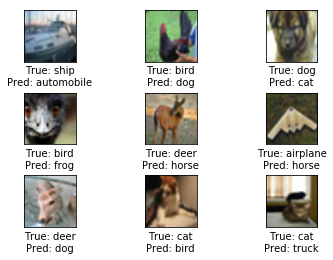

Confusion Matrix:
[895   7  16   8   3   2  10   7  28  24] (0) airplane
[  4 939   2   3   0   3   2   1   9  37] (1) automobile
[ 41   8 791  34  36  27  35  14   9   5] (2) bird
[ 14   5  52 678  32 129  49  14  12  15] (3) cat
[  4   1  46  34 814  25  32  31   7   6] (4) deer
[  4   4  29 109  24 787  14  22   2   5] (5) dog
[  6   2  25  25  12  14 907   4   3   2] (6) frog
[  8   0  19  33  30  32   4 861   1  12] (7) horse
[ 38  17  10   6   1   1   1   1 911  14] (8) ship
[ 12  53   5   6   2   0   2   5  14 901] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [52]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Homework

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Run the optimization for 100,000 iterations and see what the classification accuracy is. This will create a checkpoint that saves all the variables of the TensorFlow graph.
* Try changing the structure of the neural network to AlexNet. How does it affect the training time and the classification accuracy? Note that the checkpoints cannot be reloaded when you change the structure of the neural network.